In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
train_transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
test_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [3]:
trainset=datasets.CIFAR10(root='./data',train=True,download=True,transform=train_transform)
testset=datasets.CIFAR10('./data',train=False,download=True,transform=test_transform)
trainloader=DataLoader(trainset,batch_size=8,shuffle=True)
testloader=DataLoader(testset,batch_size=10000,shuffle=False)

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.cn1=nn.Conv2d(3,6,5)
        self.pool1=nn.AvgPool2d(2)
        self.cn2=nn.Conv2d(6,16,5)
        self.pool2=nn.AvgPool2d(2)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    def forward(self,x):
        x=F.relu(self.cn1(x))
        x=self.pool1(x)
        x=F.relu(self.cn2(x))
        x=self.pool2(x)
        x=torch.flatten(x,start_dim=1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x



In [12]:
def train(model,device,trainloader,optimizer,epoch):
    model.train()
    for batch_idx,(images,lables) in enumerate(trainloader):
        images,lables=images.to(device),lables.to(device)
        optimizer.zero_grad()
        op=model(images)
        loss=F.cross_entropy(op,lables)
        loss.backward()
        optimizer.step()
        if batch_idx%1000==0:
            print(f'Epoch {epoch} [{batch_idx * len(lables)}/{len(trainloader.dataset)} '
                f'({100. * batch_idx / len(trainloader):.0f}%)], Loss: {loss.item():.6f}')

In [5]:
def test(model,device,testloader):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for images,lables in testloader:
            images,lables=images.to(device),lables.to(device)
            _,predicted=torch.max(model(images),1)
            total+=lables.size(0)
            correct+=(predicted==lables).sum().item()
    print(f"Test Accuracy; {100*correct/total:.2f}%")

In [7]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=LeNet().to(device)

In [8]:
print(model)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [ ]:
for epoch in range(1,21):
    train(model,device,trainloader,optimizer,epoch)

In [11]:
test(model,device,testloader)

Test Accuracy; 69.67%


In [14]:
def display(model,device,testloader,num_images=5):
    model.eval()
    images,lables=next(iter(testloader))
    images,lables=images[:num_images].to(device), lables[:num_images].to(device)
    _,predicted=torch.max(model(images),1)
    fig,axes=plt.subplots(1,num_images,figsize=(20,3))
    classes=trainloader.dataset.classes
    for i in range(num_images):
        im=images[i].cpu().numpy().transpose((1,2,0))
        im=im*0.5+0.5
        axes[i].imshow(im)
        axes[i].set_title(f"Pred: {classes[predicted[i].item()]}, Actual: {classes[lables[i].item()]}")
        axes[i].axis('off')
    plt.show()

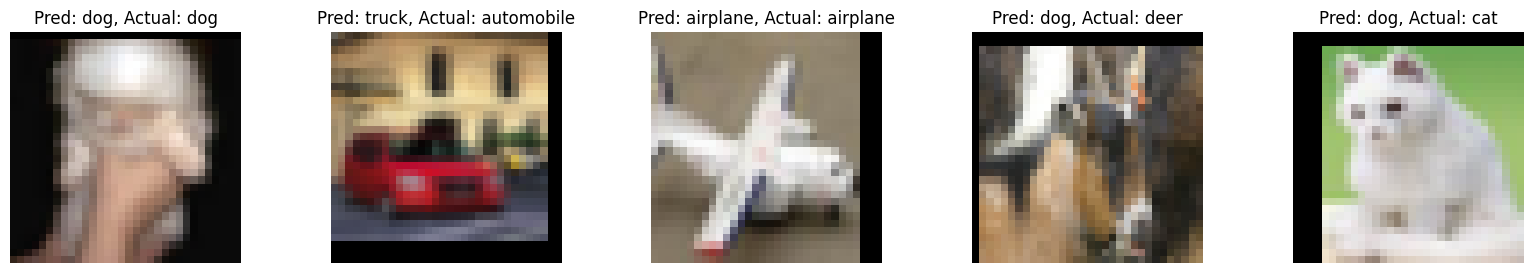

In [15]:
display(model,device,trainloader)

In [16]:
torch.save(model.state_dict(), "./Models/lenet_cifar10_20eps.pth")
print("Model saved successfully.")

Model saved successfully.


In [17]:
def predict_image(image_path,model,trainloader=trainloader):
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    transform=transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    image = transform(image).unsqueeze(0).to(device) 
    model.eval()
    with torch.no_grad():
        predicted = torch.argmax(model(image), dim=1).item()
    #image = image.cpu().numpy().transpose((1, 2, 0))
    #image = image * 0.5 + 0.5 
    
    print(f"Predicted Class: {trainloader.dataset.classes[predicted]}")

In [18]:
def load_model():
    model = LeNet().to(device)
    model.load_state_dict(torch.load("lenet_cifar10_20eps.pth"))
    model.eval()
    return model


Predicted Class: airplane


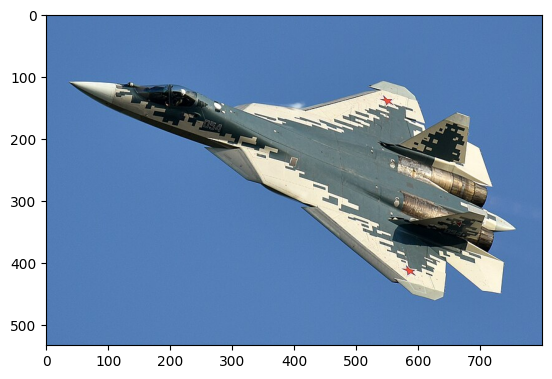

In [19]:
predict_image("./testimages/plane.jpg",model)